In [1]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

from data import Dataloader
import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [3]:
data_loader = Dataloader("../data/dataset_10")
X, Y= data_loader.load()

In [4]:
df= X-Y
Z=np.load("../data/dataset_10/Z.npy")

## Création de trois clusters par Kmeans

In [5]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(df)

predicted_labels = kmeans.labels_

score = adjusted_rand_score(Z, predicted_labels)
print("Adjusted Rand Index:", score)

Adjusted Rand Index: 0.40818680542144503


In [7]:
print(X[0])

[0.13155  0.102793 0.266773 0.273273 0.482818 0.598529 0.443253 0.079392
 0.696425 0.205184]


## Découpage en 3 dataset selon les Kmeans

In [8]:
import numpy as np

def split_dataset(X, split_table):
    dataset_0 = []
    dataset_1 = []
    dataset_2 = []

    for i in range(len(split_table)):
        if split_table[i]==0:
            dataset_0.append(X[i])
        if split_table[i]==1:
            dataset_1.append(X[i])
        if split_table[i]==2:
            dataset_2.append(X[i])

    return np.array(dataset_0),np.array(dataset_1), np.array(dataset_2)

# Example usage
X_0, X_1, X_2 = split_dataset(X, predicted_labels)

Y_0, Y_1, Y_2 = split_dataset(Y, predicted_labels)


In [9]:
print(predicted_labels)

[0 2 1 ... 0 0 0]


## Création de nos 3 models siamois

In [10]:
import numpy as np

import keras
from keras import backend
from keras.layers import Activation, Add, Dense, Input, Lambda, Dropout, Subtract
from keras.models import Model, Sequential
from keras.utils import plot_model
%pylab inline

INPUT_DIM = 10

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [11]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(INPUT_DIM, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(1))
    return seq

In [12]:
def create_meta_network(input_dim, base_network):
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    rel_score = base_network(input_a)
    irr_score = base_network(input_b)

    diff = Subtract()([rel_score, irr_score])

    prob = Activation("sigmoid")(diff)

    model = Model(inputs = [input_a, input_b], outputs = prob)
    model.compile(optimizer = "adam", loss = "binary_crossentropy")

    return model

In [13]:
base_network_1 = create_base_network(INPUT_DIM)
model_1 = create_meta_network(INPUT_DIM, base_network_1)
model_1.summary()

base_network_2 = create_base_network(INPUT_DIM)
model_2 = create_meta_network(INPUT_DIM, base_network_2)
model_2.summary()

base_network_3 = create_base_network(INPUT_DIM)
model_3 = create_meta_network(INPUT_DIM, base_network_3)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            2927        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 1)            0           ['sequential[0][0]',         

In [14]:
y_0 = np.ones((len(X_0), 1))
y_1 = np.ones((len(X_1), 1))
y_2 = np.ones((len(X_2), 1))

In [15]:
print(X_0)
print(Y_0)
print(y_0)

[[0.13155  0.102793 0.266773 ... 0.079392 0.696425 0.205184]
 [0.864225 0.929088 0.711469 ... 0.928371 0.878105 0.524462]
 [0.724375 0.862665 0.112184 ... 0.59391  0.481505 0.23749 ]
 ...
 [0.89422  0.91231  0.86633  ... 0.915527 0.302216 0.514353]
 [0.735424 0.424162 0.855697 ... 0.725909 0.126068 0.81691 ]
 [0.918344 0.570235 0.644466 ... 0.064036 0.629418 0.794183]]
[[0.093415 0.083068 0.392665 ... 0.937219 0.48561  0.801121]
 [0.74381  0.283733 0.267767 ... 0.056101 0.687921 0.599899]
 [0.50351  0.287732 0.575532 ... 0.849446 0.398026 0.84777 ]
 ...
 [0.501861 0.321797 0.842268 ... 0.45667  0.686226 0.999975]
 [0.36102  0.061197 0.27768  ... 0.646691 0.598514 0.307059]
 [0.35662  0.079526 0.753573 ... 0.527929 0.558085 0.398213]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


## Entraînnement du premier modèle

In [16]:
es=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

NUM_EPOCHS = 20
BATCH_SIZE = 10
history_1 = model_1.fit([X_0, Y_0], y_0,  
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/20
1399/1399 [==============================] - 3s 1ms/step - loss: 0.1028
Epoch 2/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0263
Epoch 3/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0210
Epoch 4/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0152
Epoch 5/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0129
Epoch 6/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0097
Epoch 7/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0098
Epoch 8/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0099
Epoch 9/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0100
Epoch 10/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0076
Epoch 11/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0068
Epoch 12/20
1399/1399 [==============================] - 2s 2ms/step - loss: 0.0097
E

KeyError: 'val_loss'

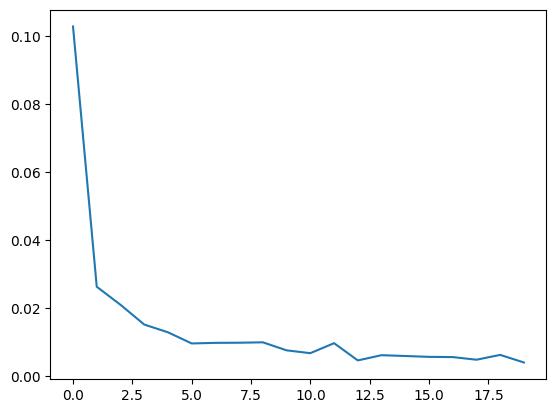

In [17]:
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Entraînnement des deux autres modèles

In [18]:
history_2 = model_2.fit([X_1, Y_1], y_1,  
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)
history_3 = model_3.fit([X_2, Y_2], y_2,  
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/20
1304/1304 [==============================] - 2s 1ms/step - loss: 0.1360
Epoch 2/20
1304/1304 [==============================] - 2s 1ms/step - loss: 0.0389
Epoch 3/20
1304/1304 [==============================] - 2s 1ms/step - loss: 0.0263
Epoch 4/20
1304/1304 [==============================] - 2s 1ms/step - loss: 0.0196
Epoch 5/20
1304/1304 [==============================] - 2s 1ms/step - loss: 0.0159
Epoch 6/20
1304/1304 [==============================] - 3s 2ms/step - loss: 0.0129
Epoch 7/20
1304/1304 [==============================] - 3s 2ms/step - loss: 0.0134
Epoch 8/20
1304/1304 [==============================] - 2s 2ms/step - loss: 0.0131
Epoch 9/20
1304/1304 [==============================] - 2s 2ms/step - loss: 0.0110
Epoch 10/20
1304/1304 [==============================] - 3s 2ms/step - loss: 0.0083
Epoch 11/20
1304/1304 [==============================] - 3s 3ms/step - loss: 0.0102
Epoch 12/20
1304/1304 [==============================] - 3s 2ms/step - loss: 0.0078
E

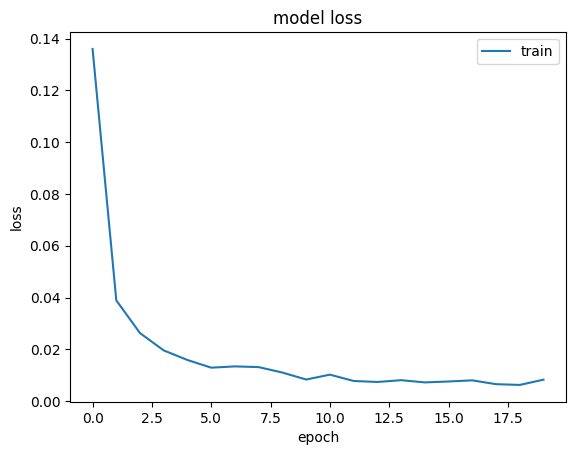

In [19]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

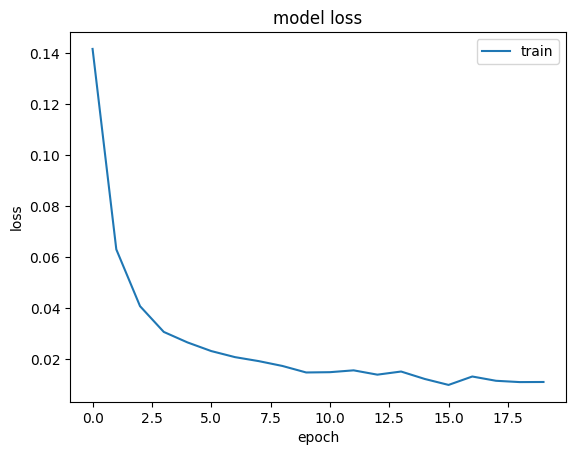

In [20]:
# summarize history for loss
plt.plot(history_3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Inférence de toutes les paires dans les 3 modèles afin de savoir lequel représente chaque paire... trop long !

In [21]:
# Initialize an empty list to store the final scores/labels for each input pair
final_scores = []

# Loop through each pair of inputs
for i in range(len(X)):
    # Predict the scores for each pair using the base networks
    score_a = base_network_1.predict(np.array([X[i]])) - base_network_1.predict(np.array([Y[i]]))
    score_b = base_network_2.predict(np.array([X[i]])) - base_network_2.predict(np.array([Y[i]]))
    score_c = base_network_3.predict(np.array([X[i]])) - base_network_3.predict(np.array([Y[i]]))

    # Collect scores in a list to use max function
    scores = [score_a, score_b, score_c]

    # Determine which model gives the max score
    max_score_index = np.argmax(scores)  # This will give 0, 1, or 2

    # Append the model index (as the cluster label) to the final scores list
    final_scores.append(max_score_index)



1/1 [==============================] - 0s 44ms/step


KeyboardInterrupt: 